<a href="https://colab.research.google.com/github/SeanBarnier/HAFS_Air-Sea/blob/main/HAFSA_ocean-atmosphere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up environment

In [ ]:
!pip install cfgrib
!pip install cartopy

In [ ]:
!sudo apt install aria2

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import cfgrib
import cartopy.crs as ccrs
import cartopy.feature as cft
import subprocess as sp

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#User parameters

In [ ]:
name = "Milton"
tcNum = "14"
trackType = ""

centralTime = dt(year=2024, month=10, day=7, hour=6) #Time when Milton began its most rapid intensification
daysBefore = 1 #Days before the focal point
daysAfter = 2 #Days after focal point

fHourStep = 3 #Normally 3 for HAFS-A
forecastLength = 63 #Normally 126 for HAFS-A. Changeable for testing.
runStep = 12 #Normally 6 for HAFS-A

figureSuffix = "_RI"
subfolder = "RITest/"
dataPath = "/content/drive/MyDrive/savedData/"
figurePath = "/content/drive/MyDrive/figures/"

stormCentered = True
if stormCentered: figureSuffix += "_SC"

Get ATCF data and find interested point

In [ ]:
cols = ["BASIN", "CY", "YYYYMMDDHH", "TECHNUM/MIN", "TECH", "TAU", "LatN/S", "LonE/W",
    "VMAX", "MSLP", "TY", "RAD", "WINDCODE", "RAD1", "RAD2", "RAD3", "RAD4",
    "POUTER", "ROUTER", "RMW", "GUSTS", "EYE", "SUBREGION", "MAXSEAS", "INITIALS",
    "DIR", "SPEED", "STORMNAME", "DEPTH", "SEAS", "SEASCODE", "SEAS1", "SEAS2",
    "SEAS3", "SEAS4", "USERDEFINED1", "Thermo1", "Thermo2", "Thermo3", "Thermo4",
    "Thermo5", "Thermo6", "Thermo7", "USERDEFINED2", "DT", "SHR82", "SHR81_1",
    "SHR82_2",  "USERDEFINED3", "SST", "USERDEFINED4", "ARMW1", "ARMW2"]

ctStr = centralTime.strftime("%Y%m%d")
ctHour = centralTime.strftime("%H")

atcfURL = f"https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/{ctStr}/{ctHour}/{tcNum}l.{ctStr}{ctHour}.hfsa.trak.atcfunix"
atcfFile = "atcf_" + ctStr + "_" + ctHour + ".csv"

!wget -O {atcfFile} {atcfURL}
atcf = pd.read_csv(atcfFile, names=cols)

In [ ]:
pointLat = int(atcf[atcf.TAU==0]["LatN/S"].iloc[0].replace("N", ""))/10
pointLon = int(atcf[atcf.TAU==0]["LonE/W"].iloc[0].replace("W", ""))/-10 #Assume western hemisphere

point = (pointLat, pointLon)
point

#Retrieve HAFS-A Data

In [ ]:
dateFormat = "%Y-%m-%d %H:%M:%S"
runFormat = "%Y%m%d%H"

start = centralTime - pd.Timedelta(days=daysBefore)
end = centralTime + pd.Timedelta(days=daysAfter)

Find times needed

In [ ]:
fcastTimes = {} #Key: initiation, item: valid time list

initTime = start
while initTime <= end:
  validTime = initTime
  fcastTimes[initTime] = []
  fhour = 0

  while validTime <= end and fhour <= forecastLength:
    fcastTimes[initTime].append(validTime)
    validTime += pd.Timedelta(hours=fHourStep)
    fhour += fHourStep

  initTime += pd.Timedelta(hours=runStep)

Find storm location in HAFS-A from ATCF files. Used to find along-storm profile.

In [ ]:
tcLocs = {}

for init, validList in fcastTimes.items():
  tcLocs[init] = {}
  initStr, initHour = init.strftime("%Y%m%d_%H").split("_")

  atcfURL = f"https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/{initStr}/{initHour}/{tcNum}l.{initStr}{initHour}.hfsa.trak.atcfunix"
  atcfFile = "atcf_" + ctStr + "_" + ctHour + ".csv"

  !wget -O {atcfFile} {atcfURL}
  atcf = pd.read_csv(atcfFile, names=cols)

  for valid in validList:
    fHour = int((valid-init).total_seconds() / 3600)

    pointLat = int(atcf[atcf.TAU==fHour]["LatN/S"].iloc[0].replace("N", ""))/10
    pointLon = int(atcf[atcf.TAU==fHour]["LonE/W"].iloc[0].replace("W", ""))/-10 #Assume western hemisphere
    tcLocs[init][valid] = (pointLat, pointLon)

Get data from HAFS-A output.

In [ ]:
fcastTimes

In [ ]:
atm = {}

for init, validList in fcastTimes.items():

  atm[init] = {}
  initTime = init.strftime("%Y%m%d%H")

  for valid in validList:
    atm[init][valid] = {}

    fhour = str(int((valid-init).total_seconds() / 3600))
    while len(fhour) < 3: fhour = "0" + fhour

    atmFile = "hafsa_" + initTime + "_f" + fhour + ".nc"
    atmPath = dataPath + "hafsaOutput/" + subfolder + atmFile
    atmData = xr.open_dataset(atmPath)

    if stormCentered: point = tcLocs[init][valid]

    for layer in atmData.isobaricInhPa.data:
      #Longitude in atm files are in degrees east, but are -180 - 180 in oce files. point has them from -180 - 180
      validPoint = atmData.sel(latitude=point[0], longitude=point[1] + 360, isobaricInhPa=layer, method="nearest")

      atm[init][valid][layer] = {}
      atm[init][valid][layer]["T"] = float(validPoint.t.data)
      atm[init][valid][layer]["q"] = float(validPoint.q.data) * 1000 #Convert from kg/kg to g/kg
      atm[init][valid][layer]["u"] = float(validPoint.u.data)
      atm[init][valid][layer]["v"] = float(validPoint.v.data)
      atm[init][valid][layer]["gh"] = float(validPoint.gh.data)

In [ ]:
atm

In [ ]:
oce = {}

for init, validList in fcastTimes.items():

  oce[init] = {}
  initTime = init.strftime("%Y%m%d%H")

  for valid in validList:
    oce[init][valid] = {}

    fhour = str(int((valid-init).total_seconds() / 3600))
    while len(fhour) < 3: fhour = "0" + fhour

    #oceURL = bucket + initDate + "/" + initHour + "/" + tcNum + "l." + initDate + initHour + ".hfsa.mom6.f" + fhour + ".nc"
    oceFile = "mom6_" + initTime + "_f" + fhour + ".nc"
    ocePath = dataPath + "mom6Output/" + subfolder + oceFile
    oceData = xr.open_dataset(ocePath, decode_times=False)

    if stormCentered: point = tcLocs[init][valid]

    for layer in oceData.z_l.data:
      oce[init][valid][layer] = {}
      oce[init][valid][layer]["T"] = float(oceData.sel(yq=point[0], yh=point[0], xh=point[1], xq=point[1], z_l=layer, method="nearest").temp.data) + 273.15 #This is potential temperature. Converted from C to K.
      oce[init][valid][layer]["s"] = float(oceData.sel(yq=point[0], yh=point[0], xh=point[1], xq=point[1], z_l=layer, method="nearest").so.data)
      oce[init][valid][layer]["u"] = float(oceData.sel(yq=point[0], yh=point[0], xh=point[1], xq=point[1], z_l=layer, method="nearest").uo.data)
      oce[init][valid][layer]["v"] = float(oceData.sel(yq=point[0], yh=point[0], xh=point[1], xq=point[1], z_l=layer, method="nearest").vo.data)

In [ ]:
oce

Create figure of model parameters

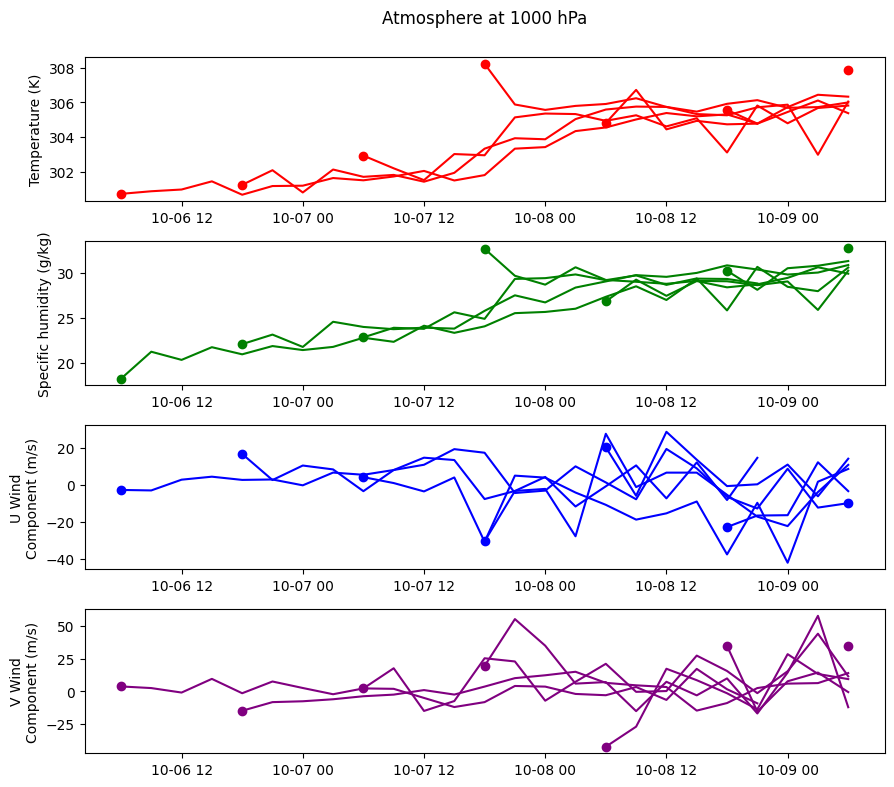

In [244]:
atmFig = plt.figure(figsize=(10,8))
tAx = atmFig.add_axes([0.1, 0.74, 0.8, 0.18])
qAx = atmFig.add_axes([0.1, 0.51, 0.8, 0.18])
uAx = atmFig.add_axes([0.1, 0.28, 0.8, 0.18])
vAx = atmFig.add_axes([0.1, 0.05, 0.8, 0.18])

atmLevel = 1000.0
for runTime, run in zip(atm.keys(), atm.values()):
  time = run.keys()
  t = [atm[runTime][timestep][atmLevel]["T"] for timestep in time]
  q = [atm[runTime][timestep][atmLevel]["q"] for timestep in time]
  u = [atm[runTime][timestep][atmLevel]["u"] for timestep in time]
  v = [atm[runTime][timestep][atmLevel]["v"] for timestep in time]

  tAx.plot(time, t, color="red")
  qAx.plot(time, q, color="green")
  uAx.plot(time, u, color="blue")
  vAx.plot(time, v, color="purple")

tAx.scatter(atm.keys(), [atm[runTime][runTime][atmLevel]["T"] for runTime in atm.keys()], color="red")
qAx.scatter(atm.keys(), [atm[runTime][runTime][atmLevel]["q"] for runTime in atm.keys()], color="green")
uAx.scatter(atm.keys(), [atm[runTime][runTime][atmLevel]["u"] for runTime in atm.keys()], color="blue")
vAx.scatter(atm.keys(), [atm[runTime][runTime][atmLevel]["v"] for runTime in atm.keys()], color="purple")

tAx.set_ylabel("Temperature (K)")
qAx.set_ylabel("Specific humidity (g/kg)")
uAx.set_ylabel("U Wind\nComponent (m/s)")
vAx.set_ylabel("V Wind\nComponent (m/s)")

atmFig.suptitle(f"Atmosphere at {int(atmLevel)} hPa")
plt.savefig(f"atmParameters_{int(atmLevel)}hPa{figureSuffix}.png")
plt.show()

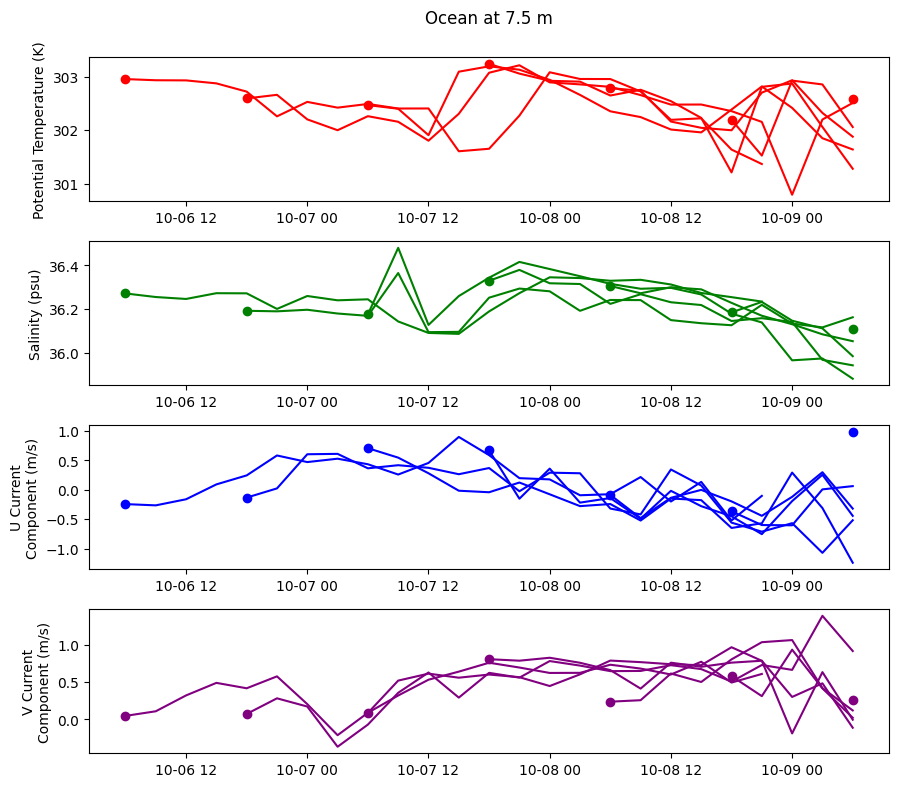

In [245]:
oceFig = plt.figure(figsize=(10,8))
tAx = oceFig.add_axes([0.1, 0.74, 0.8, 0.18])
sAx = oceFig.add_axes([0.1, 0.51, 0.8, 0.18])
uAx = oceFig.add_axes([0.1, 0.28, 0.8, 0.18])
vAx = oceFig.add_axes([0.1, 0.05, 0.8, 0.18])

oceLevel = 7.5
for runTime, run in zip(oce.keys(), oce.values()):
  time = run.keys()
  t = [oce[runTime][timestep][oceLevel]["T"] for timestep in time]
  s = [oce[runTime][timestep][oceLevel]["s"] for timestep in time]
  u = [oce[runTime][timestep][oceLevel]["u"] for timestep in time]
  v = [oce[runTime][timestep][oceLevel]["v"] for timestep in time]

  tAx.plot(time, t, color="red")
  sAx.plot(time, s, color="green")
  uAx.plot(time, u, color="blue")
  vAx.plot(time, v, color="purple")

tAx.scatter(oce.keys(), [oce[runTime][runTime][oceLevel]["T"] for runTime in oce.keys()], color="red")
sAx.scatter(oce.keys(), [oce[runTime][runTime][oceLevel]["s"] for runTime in oce.keys()], color="green")
uAx.scatter(oce.keys(), [oce[runTime][runTime][oceLevel]["u"] for runTime in oce.keys()], color="blue")
vAx.scatter(oce.keys(), [oce[runTime][runTime][oceLevel]["v"] for runTime in oce.keys()], color="purple")

tAx.set_ylabel("Potential Temperature (K)")
sAx.set_ylabel("Salinity (psu)")
uAx.set_ylabel("U Current\nComponent (m/s)")
vAx.set_ylabel("V Current\nComponent (m/s)")

oceFig.suptitle(f"Ocean at {round(oceLevel,1)} m")
plt.savefig(f"oceParameters_{int(oceLevel)}m{figureSuffix}.png")
plt.show()

Profiles

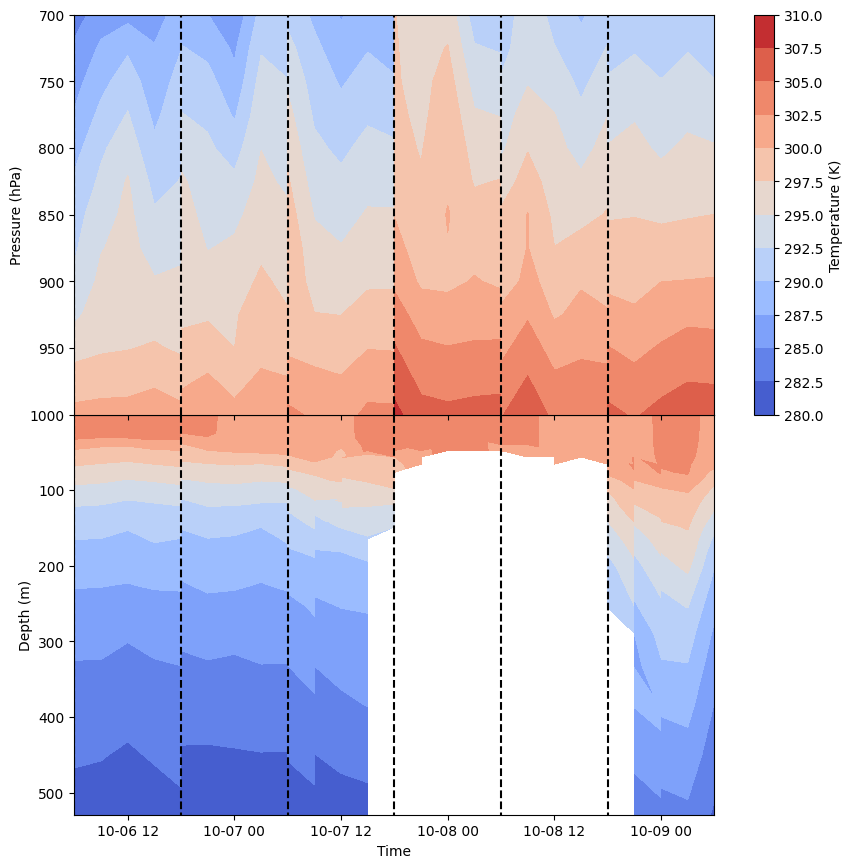

In [246]:
profFig = plt.figure(figsize=(10,10))
oceAx = profFig.add_axes([0.1, 0.1, 0.64, 0.4])
oceAx.invert_yaxis()
atmAx = profFig.add_axes([0.1, 0.5, 0.8, 0.4])
atmAx.invert_yaxis()

var = "T"
levs = {"T":np.arange(280,311,2.5), "u":np.arange(-30,31,5), "v":np.arange(-30,31,5)}[var]

for runTime, run in zip(list(oce.keys())[:-1], oce.values()): #Cannot plot last run because it only has one valid time
  time = list(run)
  ocez = list(oce[runTime][time[0]].keys()) #Should be the same for every timestep
  oceT = [[oce[runTime][timestep][level][var] for timestep in time] for level in ocez]

  oceAx.contourf(time, ocez, oceT, cmap="coolwarm", levels=levs)
  oceAx.plot([runTime]*len(ocez), ocez, color="black", linestyle="--")

  atmz = list(atm[runTime][time[0]].keys()) #Should be the same for every timestep
  atmT = [[atm[runTime][timestep][level][var] for timestep in time] for level in atmz]

  contour = atmAx.contourf(time, atmz, atmT, cmap="coolwarm", levels=levs)
  atmAx.plot([runTime]*len(atmz), atmz, color="black", linestyle="--")

oceAx.set_xlabel("Time")
oceAx.set_ylabel("Depth (m)")
atmAx.set_ylabel("Pressure (hPa)")
atmAx.set_xticklabels([])

profFig.colorbar(contour, label="Temperature (K)", ticks=levs)
plt.savefig(f"{var}profile{figureSuffix}.png")
plt.show()